Actividad 1, 2 y 3
---

In [8]:
###Hecho por Gabriel Ferrer (Con apoyo de IA, pero tiene horas en prompt para que llegue a lo que tiene que hacer y un par de cosas extra)###
import pandas as pd  # Para manejar datos en DataFrames
import numpy as np  # Para operaciones numéricas y arrays
import matplotlib.pyplot as plt  # Para generar gráficos
from matplotlib.patches import Rectangle  # Para dibujar rectángulos en gráficos
import os  # Para manejar rutas de archivos y nombres

class ImagenTermo:
    """
    Clase para manipular y analizar imágenes termográficas almacenadas como matrices de temperaturas.
    Funcionalidades: Cargar datos desde archivos (XLSX, CSV, NPY), extraer temperaturas de subcuadrantes específicos
    (filtrando >29°C), calcular estadísticas (max, min, mean, std, var, median), y generar visualizaciones
    (histogramas comparativos, mapas de calor de deltas, divisiones de imagen, subcuadrantes destacados,
    cuadrantes con histogramas).
    """
    # Método de clase para cargar una imagen desde un archivo
    @classmethod
    def from_file(cls, filename):
        # Verifica el formato del archivo y carga los datos
        if filename.endswith('.xlsx'):  # Si es un archivo Excel
            df = pd.read_excel(filename, header=None)  # Lee el Excel sin cabecera
            data = df.to_numpy()  # Convierte el DataFrame a un array de NumPy
        elif filename.endswith('.csv'):  # Si es un archivo CSV
            data = np.genfromtxt(filename, delimiter=',')  # Carga el CSV como array de NumPy
        elif filename.endswith('.npy'):  # Si es un archivo NumPy
            data = np.load(filename)  # Carga el archivo NumPy directamente
        else:  # Si el formato no es soportado
            raise ValueError("Formato de archivo no compatible. Usa .xlsx, .csv o .npy.")  # Tira un error
        # Toma la dosis del nombre del archivo, asumiendo formato "Imagen_#.xlsx"
        base = os.path.basename(filename)  # Obtiene el nombre base del archivo
        try:  # Intenta parsear la dosis
            dose_str = base.split('_')[1].split('.')[0]  # Extrae la parte de la dosis
            dose = int(dose_str)  # Convierte a entero
        except (IndexError, ValueError):  # Si falla el parseo
            dose = 0  # Valor predeterminado de 0
        # Retorna una instancia de la clase con los datos y la dosis
        return cls(data, dose)

    # Constructor
    def __init__(self, data, dose=0):
        # Verifica que los datos sean un array de NumPy
        if isinstance(data, np.ndarray):  # Si es un ndarray
            self.data = data  # Asigna los datos
        else:  # Si no lo es
            raise ValueError("Los datos deben ser un numpy ndarray.")  # Tira error
        self.dose = dose  # Asigna la dosis

    # Método para extraer temperaturas por encima de un umbral en un subcuadrante específico
    def get_subquad_temps(self, row, sub, quadrant, threshold=29.0):
        """
        Extrae temperaturas por encima del umbral de un subcuadrante específico.
        row: 0 para fila1, 1 para fila2, 2 para fila3
        sub: 1 para .1, 2 para .2, 3 para .3, 4 para .4
        quadrant: 'no_irradiado' o 'irradiado'
        """
        r_start = row * 40  # Calcula el inicio de la fila (cada fila tiene 40 píxeles)
        r_end = r_start + 40  # Calcula el fin de la fila
        if quadrant == 'no_irradiado':  # Para el cuadrante no irradiado
            c_start = (sub - 1) * 20  # Calcula el inicio de la columna (orden normal)
        else:  # Para el cuadrante irradiado
            c_start = 80 + (4 - sub) * 20  # Calcula el inicio de la columna (orden invertido)
        c_end = c_start + 20  # Calcula el fin de la columna
        sub_data = self.data[r_start:r_end, c_start:c_end]  # Extrae el subcuadrante
        # Retorna las temperaturas planas por encima del umbral
        return sub_data[sub_data > threshold].flatten()

    # Método para graficar histogramas comparativos de subcuadrantes seleccionados
    def plot_comparative_subquad_histograms(self):
        """
        Grafica histogramas comparativos para subcuadrantes seleccionados 2.1, 2.2, 2.3, 3.1, 3.2, 3.3.
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)  # Crea una figura con 2x3 subgráficos
        axes = axes.flatten()  # Aplana los ejes
        k = 0  # Contador para los ejes
        for r in [1, 2]:  # Para filas 2 y 3
            for s in range(3):  # Para subcuadrantes 1, 2, 3
                temps_non = self.get_subquad_temps(r, s+1, 'no_irradiado')  # Obtiene temperaturas no irradiadas
                temps_irr = self.get_subquad_temps(r, s+1, 'irradiado')  # Obtiene temperaturas irradiadas
                ax = axes[k]  # Selecciona el eje actual
                # Grafica histograma no irradiado en verde
                ax.hist(temps_non, bins=30, alpha=0.5, label=f'CNir{r+1}.{s+1}', color='green')
                # Grafica histograma irradiado en rojo
                ax.hist(temps_irr, bins=30, alpha=0.5, label=f'Cir{r+1}.{s+1}', color='red')
                ax.legend()  # Agrega leyenda
                ax.set_xlabel('Temperatura (°C)')  # Etiqueta del eje x
                ax.set_xlim(30, 38)  # Limita el eje x
                k += 1  # Incrementa el contador
        # Título superior de la figura
        plt.suptitle(f'Distribución de temperaturas para subcuadrantes irradiados (rojo) y no irradiados (verde)')
        plt.tight_layout()  # Ajusta el layout
        plt.show()  # Muestra la figura

    # Método para graficar un mapa de calor de deltas de temperatura
    def plot_delta_heatmap(self):
        """
        Grafica un mapa de calor de delta de temperatura para segmentos seleccionados (2.1, 2.2, 2.3, 3.1, 3.2, 3.3).
        """
        deltas = np.zeros((2, 3))  # Inicializa matriz de deltas 2x3
        labels = [['', '', ''], ['', '', '']]  # Inicializa etiquetas
        for rr in range(2):  # Para filas 2 y 3 (rr=0 para fila2, rr=1 para fila3)
            r = rr + 1  # Ajusta el índice de fila
            for s in range(3):  # Para subcuadrantes 1, 2, 3
                temps_non = self.get_subquad_temps(r, s+1, 'no_irradiado')  # Obtiene temperaturas no irradiadas
                temps_irr = self.get_subquad_temps(r, s+1, 'irradiado')  # Obtiene temperaturas irradiadas
                mean_non = np.mean(temps_non) if len(temps_non) > 0 else 0  # Calcula media no irradiada
                mean_irr = np.mean(temps_irr) if len(temps_irr) > 0 else 0  # Calcula media irradiada
                deltas[rr, s] = mean_irr - mean_non  # Calcula delta
                labels[rr][s] = f'Cir{r+1}.{s+1}-CNir{r+1}.{s+1}'  # Asigna etiqueta
        fig, ax = plt.subplots()  # Crea figura y eje
        # Muestra la imagen con colormap RdBu_r
        im = ax.imshow(deltas, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
        ax.set_xticks(np.arange(3))  # Configura ticks x
        ax.set_xticklabels(['.1', '.2', '.3'])  # Etiquetas x
        ax.set_yticks(np.arange(2))  # Configura ticks y
        ax.set_yticklabels(['Row 2', 'Row 3'])  # Etiquetas y
        # Título del gráfico
        ax.set_title(f'Delta temps. promedios entre Cir y CNir - Dose {self.dose} cGy')
        # Añade anotaciones de texto
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, f"{deltas[i, j]:.2f}\n{labels[i][j]}", ha="center", va="center", color="black")
        fig.colorbar(im, ax=ax)  # Agrega barra de color
        plt.show()  # Muestra la figura

    # Método para obtener estadísticas de un cuadrante
    def get_quadrant_stats(self, threshold, quadrant):
        """
        Retorna estadísticas (max, min, mean, std, var, median) para temperaturas por encima del umbral dado en el cuadrante especificado.
        quadrant puede ser 'no_irradiado' o 'irradiado'.
        Usa subcuadrantes seleccionados (2.1, 2.2, 2.3, 3.1, 3.2, 3.3).
        """
        temps_list = []  # Lista para recopilar temperaturas
        for r in [1, 2]:  # Para filas 2 y 3
            for s in [1, 2, 3]:  # Para subcuadrantes .1, .2, .3
                temps_list.append(self.get_subquad_temps(r, s, quadrant, threshold))  # Añade temperaturas
        temps = np.concatenate(temps_list)  # Concatena todas las temperaturas
        if len(temps) == 0:  # Si no hay temperaturas
            # Retorna None para todas las estadísticas
            return {
                'max': None,
                'min': None,
                'mean': None,
                'std': None,
                'var': None,
                'median': None
            }
        # Calcula y retorna las estadísticas
        return {
            'max': np.max(temps),
            'min': np.min(temps),
            'mean': np.mean(temps),
            'std': np.std(temps),
            'var': np.var(temps),
            'median': np.median(temps)
        }

    # Método para graficar la imagen dividida en subcuadrantes
    def plot_divisions(self):
        """
        Grafica la imagen dividida en subcuadrantes.
        Izquierda: no irradiado (CNir), Derecha: irradiado (Cir).
        """
        if self.data.shape != (120, 160):  # Verifica la forma de los datos
            raise ValueError("La forma de los datos debe ser (120, 160) para divisiones.")  # Tira error si no coincide
        fig, ax = plt.subplots(figsize=(12, 6))  # Crea figura y eje
        ax.imshow(self.data, cmap='gray')  # Muestra la imagen en escala de grises
        # Título del gráfico
        ax.set_title('Subcuadrantes obtenidos de la división de los cuadrantes no irradiados y irradiados.')
        # Dibuja líneas de rejilla
        for i in range(1, 8):
            ax.axvline(i * 20, color='white', linewidth=1)  # Líneas verticales
        for i in range(1, 3):
            ax.axhline(i * 40, color='white', linewidth=1)  # Líneas horizontales
        # Etiquetas para izquierda: no irradiado (CNir, orden normal: .1 izquierda exterior, .4 derecha interior)
        labels_non = [
            ['CNir1.1', 'CNir1.2', 'CNir1.3', 'CNir1.4'],
            ['CNir2.1', 'CNir2.2', 'CNir2.3', 'CNir2.4'],
            ['CNir3.1', 'CNir3.2', 'CNir3.3', 'CNir3.4']
        ]
        for r in range(3):  # Para cada fila
            for c in range(4):  # Para cada columna
                # Añade texto de etiqueta
                ax.text(c * 20 + 10, r * 40 + 20, labels_non[r][c], ha='center', va='center', color='white', fontsize=8)
        # Etiquetas para derecha: irradiado (Cir, invertido: .4 izquierda interior, .1 derecha exterior)
        labels_irr = [
            ['Cir1.4', 'Cir1.3', 'Cir1.2', 'Cir1.1'],
            ['Cir2.4', 'Cir2.3', 'Cir2.2', 'Cir2.1'],
            ['Cir3.4', 'Cir3.3', 'Cir3.2', 'Cir3.1']
        ]
        for r in range(3):  # Para cada fila
            for c in range(4):  # Para cada columna
                # Añade texto de etiqueta
                ax.text(80 + c * 20 + 10, r * 40 + 20, labels_irr[r][c], ha='center', va='center', color='white', fontsize=8)
        ax.axis('off')  # Apaga los ejes
        plt.show()  # Muestra la figura

    # Método para graficar subcuadrantes seleccionados destacados
    def plot_selected_subquadrants(self):
        """
        Grafica la imagen con subcuadrantes seleccionados.
        """
        if self.data.shape != (120, 160):  # Verifica la forma de los datos
            raise ValueError("La forma de los datos debe ser (120, 160) para divisiones.")  # Tira error si no coincide
        fig, ax = plt.subplots(figsize=(12, 6))  # Crea figura y eje
        ax.imshow(self.data, cmap='gray')  # Muestra la imagen en escala de grises
        # Título del gráfico
        ax.set_title('Subcuadrantes de interés.')
        # Dibuja líneas de rejilla
        for i in range(1, 8):
            ax.axvline(i * 20, color='white', linewidth=1)  # Líneas verticales
        for i in range(1, 3):
            ax.axhline(i * 40, color='white', linewidth=1)  # Líneas horizontales
        # Etiquetas iguales a plot_divisions
        labels_non = [
            ['CNir1.1', 'CNir1.2', 'CNir1.3', 'CNir1.4'],
            ['CNir2.1', 'CNir2.2', 'CNir2.3', 'CNir2.4'],
            ['CNir3.1', 'CNir3.2', 'CNir3.3', 'CNir3.4']
        ]
        for r in range(3):  # Para cada fila
            for c in range(4):  # Para cada columna
                # Añade texto de etiqueta
                ax.text(c * 20 + 10, r * 40 + 20, labels_non[r][c], ha='center', va='center', color='white', fontsize=8)
        labels_irr = [
            ['Cir1.4', 'Cir1.3', 'Cir1.2', 'Cir1.1'],
            ['Cir2.4', 'Cir2.3', 'Cir2.2', 'Cir2.1'],
            ['Cir3.4', 'Cir3.3', 'Cir3.2', 'Cir3.1']
        ]
        for r in range(3):  # Para cada fila
            for c in range(4):  # Para cada columna
                # Añade texto de etiqueta
                ax.text(80 + c * 20 + 10, r * 40 + 20, labels_irr[r][c], ha='center', va='center', color='white', fontsize=8)
        # Cajas amarillas para seleccionados
        # Izquierda no irradiada: CNir .1, .2, .3 (excluyendo .4), x=0-60, ancho=60 para filas 2 y 3
        ax.add_patch(Rectangle((0, 40), 60, 40, fill=False, edgecolor='yellow', linewidth=2))  # Añade rectángulo para fila 2 izquierda
        ax.add_patch(Rectangle((0, 80), 60, 40, fill=False, edgecolor='yellow', linewidth=2))  # Añade rectángulo para fila 3 izquierda
        # Derecha irradiada: Cir .1, .2, .3 (c=1,2,3: x=100-160, ancho=60)
        ax.add_patch(Rectangle((100, 40), 60, 40, fill=False, edgecolor='yellow', linewidth=2))  # Añade rectángulo para fila 2 derecha
        ax.add_patch(Rectangle((100, 80), 60, 40, fill=False, edgecolor='yellow', linewidth=2))  # Añade rectángulo para fila 3 derecha
        ax.axis('off')  # Apaga los ejes
        plt.show()  # Muestra la figura

    # Método para graficar cuadrantes con histogramas
    def plot_quadrants_with_histograms(self):
        """
        Grafica los cuadrantes no irradiado (izquierda) e irradiado (derecha) con sus histogramas.
        Solo considera temperaturas > 29°C para los histogramas y estadísticas.
        Imprime las estadísticas para cada cuadrante.
        """
        if self.data.shape != (120, 160):  # Verifica la forma de los datos
            raise ValueError("La forma de los datos debe ser (120, 160) para cuadrantes.")  # Tira error si no coincide
        dose = self.dose  # Obtiene la dosis
        left = self.data[:, :80]  # Cuadrante izquierdo: no irradiado
        right = self.data[:, 80:]  # Cuadrante derecho: irradiado
        # Gráfico para no irradiado (izquierda)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Crea figura con 1x2 subgráficos
        im = axs[0].imshow(left, cmap='hot', vmin=26, vmax=40)  # Muestra imagen con colormap hot
        axs[0].set_title(f'Cuadrante no irradiado - {dose} cGy')  # Título
        axs[0].set_xlabel('')  # Etiqueta x vacía
        axs[0].set_ylabel('')  # Etiqueta y vacía
        fig.colorbar(im, ax=axs[0], orientation='vertical')  # Barra de color
        left_flat = left.flatten()  # Aplana el cuadrante
        temps_left = left_flat[left_flat > 29]  # Filtra temperaturas >29
        axs[1].hist(temps_left, bins=50, color='orange')  # Histograma
        axs[1].set_title('')  # Título vacío
        axs[1].set_xlabel('Temperatura (°C)')  # Etiqueta x
        axs[1].set_ylabel('')  # Etiqueta y vacía
        axs[1].set_xlim(29, 40)  # Limita eje x
        plt.tight_layout()  # Ajusta layout
        plt.show()  # Muestra figura
        # Calcula e imprime estadísticas para no irradiado
        stats_non = self.get_quadrant_stats(29, 'no_irradiado')
        print("Estadísticas para el cuadrante no irradiado (>29°C):")
        for key, value in stats_non.items():
            print(f"{key}: {value}")
        # Gráfico para irradiado (derecha)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Crea otra figura
        im = axs[0].imshow(right, cmap='hot', vmin=26, vmax=40)  # Muestra imagen
        axs[0].set_title(f'Cuadrante irradiado - {dose} cGy')  # Título
        axs[0].set_xlabel('')  # Etiqueta x vacía
        axs[0].set_ylabel('')  # Etiqueta y vacía
        fig.colorbar(im, ax=axs[0], orientation='vertical')  # Barra de color
        right_flat = right.flatten()  # Aplana el cuadrante
        temps_right = right_flat[right_flat > 29]  # Filtra temperaturas >29
        axs[1].hist(temps_right, bins=50, color='orange')  # Histograma
        axs[1].set_title('')  # Título vacío
        axs[1].set_xlabel('Temperatura (°C)')  # Etiqueta x
        axs[1].set_ylabel('')  # Etiqueta y vacía
        axs[1].set_xlim(29, 40)  # Limita eje x
        plt.tight_layout()  # Ajusta layout
        plt.show()  # Muestra figura
        # Calcula e imprime estadísticas para irradiado
        stats_irr = self.get_quadrant_stats(29, 'irradiado')
        print("Estadísticas para el cuadrante irradiado (>29°C):")
        for key, value in stats_irr.items():
            print(f"{key}: {value}")

# Función para computar datos de un paciente
def compute_patient_data(files, patient_id=1):
    """
    Computa los datos para un solo paciente desde sus archivos.
    Retorna un DataFrame con las estadísticas.
    """
    data = []  # Lista para recopilar datos
    for file in files:  # Para cada archivo
        img = ImagenTermo.from_file(file)  # Carga la imagen
        dose = img.dose  # Obtiene la dosis
        stats_irr = img.get_quadrant_stats(29, 'irradiado')  # Estadísticas irradiadas
        stats_non = img.get_quadrant_stats(29, 'no_irradiado')  # Estadísticas no irradiadas
        # Añade diccionario con datos
        data.append({
            'Paciente': patient_id,
            'Dosis': dose,
            'Temp media (irr)': stats_irr['mean'],
            'Var (irr)': stats_irr['var'],
            'std (irr)': stats_irr['std'],
            'max (irr)': stats_irr['max'],
            'min (irr)': stats_irr['min'],
            'Temp media (non)': stats_non['mean'],
            'Var (non)': stats_non['var'],
            'std (non)': stats_non['std'],
            'max (non)': stats_non['max'],
            'min (non)': stats_non['min']
        })
    # Retorna DataFrame ordenado por dosis
    return pd.DataFrame(data).sort_values('Dosis')

# Función para generar tablas de estadísticas
def generate_stats_tables(patient_files_list):
    """
    Genera tablas A, B, C y D para todos los pacientes.
    patient_files_list: Lista de listas, cada lista interna es archivos para un paciente.
    """
    all_df = pd.DataFrame()  # DataFrame vacío para todos los datos
    for patient_id, files in enumerate(patient_files_list, start=1):  # Para cada paciente
        patient_df = compute_patient_data(files, patient_id)  # Computa datos del paciente
        all_df = pd.concat([all_df, patient_df], ignore_index=True)  # Concatena
    # Tabla A: Mama irradiada (todos los pacientes)
    table_a = all_df[['Paciente', 'Dosis', 'Temp media (irr)', 'Var (irr)', 'std (irr)', 'max (irr)', 'min (irr)']]
    table_a.columns = ['Paciente', 'Dosis', 'Temp media', 'Var', 'std', 'max', 'min']  # Renombra columnas
    print("Tabla A - Mama irradiada:")  # Imprime título
    print(table_a.to_string(index=False))  # Imprime tabla sin índice
    # Tabla B: Mama no irradiada (todos los pacientes)
    table_b = all_df[['Paciente', 'Dosis', 'Temp media (non)', 'Var (non)', 'std (non)', 'max (non)', 'min (non)']]
    table_b.columns = ['Paciente', 'Dosis', 'Temp media', 'Var', 'std', 'max', 'min']  # Renombra columnas
    print("Tabla B - Mama no irradiada:")  # Imprime título
    print(table_b.to_string(index=False))  # Imprime tabla sin índice
    # Tabla C: Combinada (todos los pacientes)
    print("Tabla C - Estadísticas totales:")  # Imprime título
    print(all_df.to_string(index=False))  # Imprime tabla sin índice
    # Tabla D: Diferencias (delta) de temperaturas medias (irr - non), pivote para pacientes vs dosis
    deltas = all_df['Temp media (irr)'] - all_df['Temp media (non)']  # Calcula deltas
    all_df['Delta'] = deltas  # Añade columna Delta
    table_d = all_df.pivot(index='Paciente', columns='Dosis', values='Delta')  # Pivotea la tabla
    print("Tabla D - Diferencia (delta) de temperaturas medias:")  # Imprime título
    print(table_d.to_string())  # Imprime tabla

Prueba
---

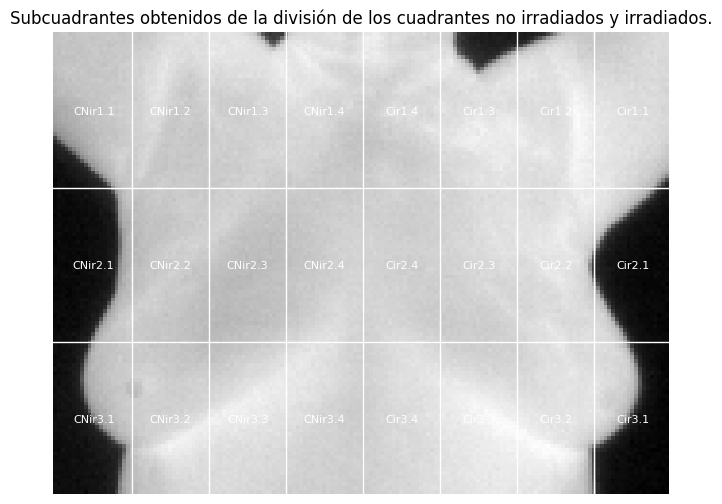

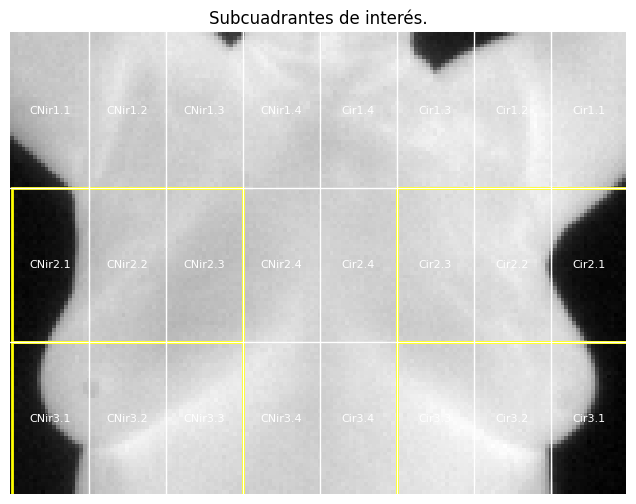

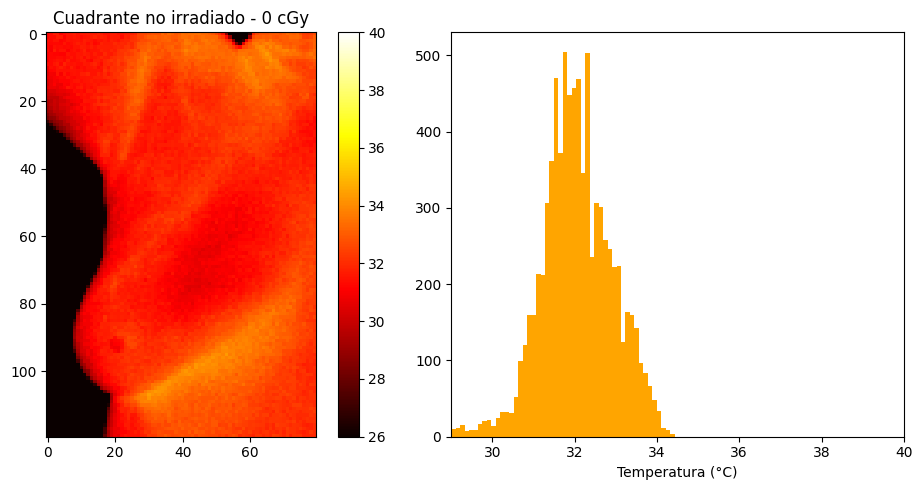

Estadísticas para el cuadrante no irradiado (>29°C):
max: 34.4315795898438
min: 29.0001983642578
mean: 31.87314595755059
std: 0.9351381357940951
var: 0.8744833330164554
median: 31.7411041259766


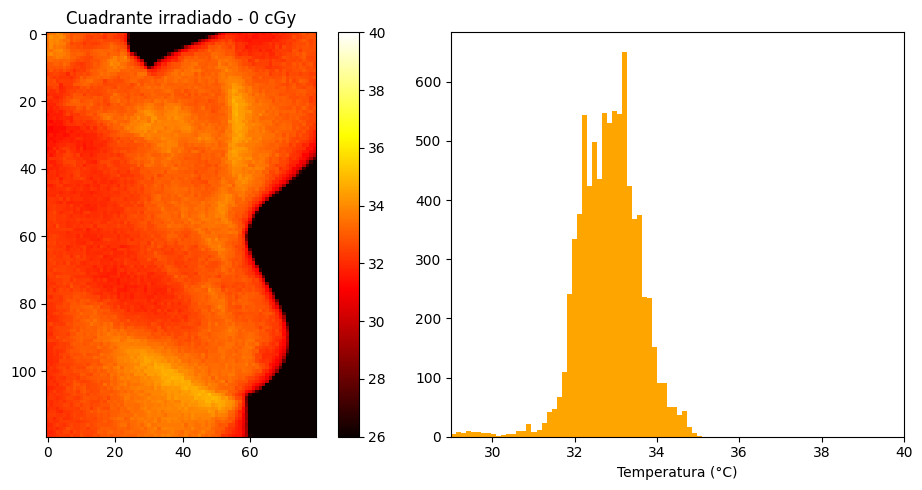

Estadísticas para el cuadrante irradiado (>29°C):
max: 35.1042022705078
min: 29.0001983642578
mean: 32.955099606389496
std: 0.8129496306791194
var: 0.6608871020213166
median: 33.0190887451172
Tabla A - Mama irradiada:
 Paciente  Dosis  Temp media      Var      std       max       min
        1      0   32.955100 0.660887 0.812950 35.104202 29.000198
        1   1000   33.007094 0.433884 0.658699 34.599747 29.067459
        1   2000   33.572641 0.612135 0.782390 35.793655 29.000198
        1   3000   33.613018 0.487599 0.698283 35.154633 29.084259
        1   4000   33.874535 0.505685 0.711115 35.406891 29.067459
        1   5000   35.065269 0.683751 0.826892 36.583954 29.000198
        2      0   33.208464 0.601463 0.775540 34.986496 29.067459
        2   1000   32.654971 0.459267 0.677693 34.515671 29.117905
        2   2000   32.135596 0.438706 0.662349 34.246613 29.067459
        2   3000   32.883609 0.494014 0.702862 34.414780 29.000198
        2   4000   33.617298 0.532292 0.72958

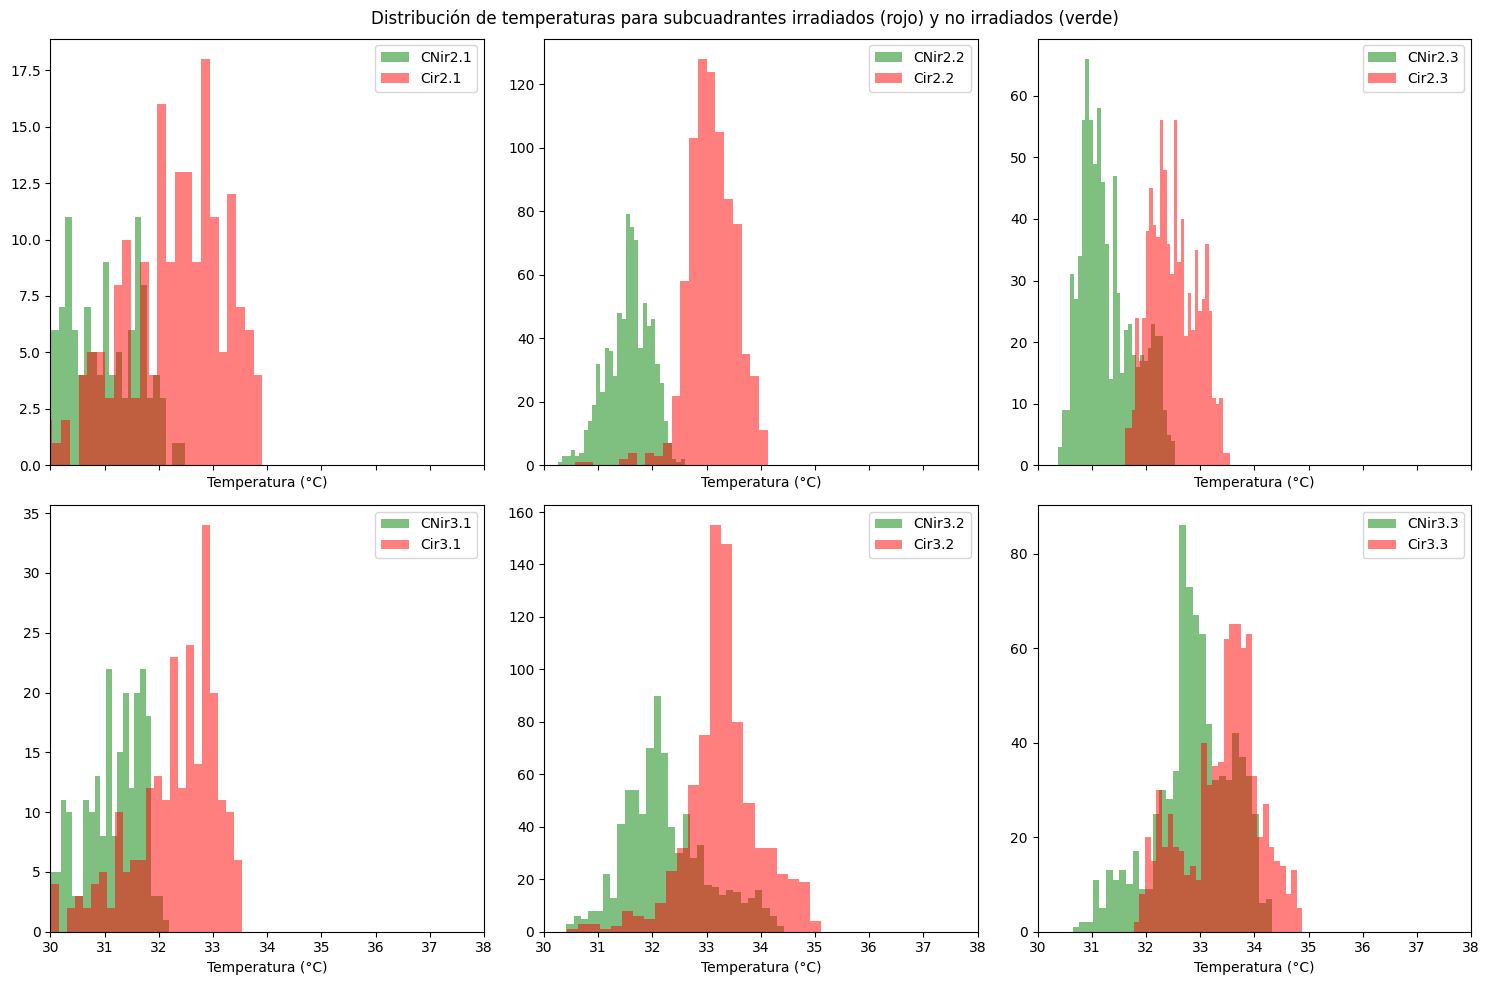

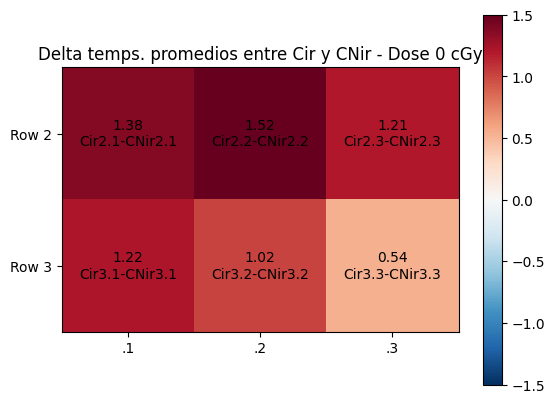

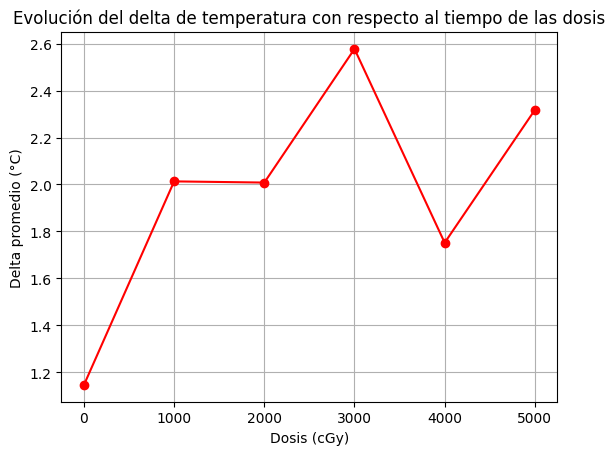

In [9]:
# Carga la imagen para Actividad 1
img = ImagenTermo.from_file('Imagen_0.xlsx')  # Carga archivo específico
img.plot_divisions()  # Grafica divisiones
img.plot_selected_subquadrants()  # Grafica subcuadrantes seleccionados
img.plot_quadrants_with_histograms()  # Grafica cuadrantes con histogramas
# Para Actividad 2 con múltiples pacientes
patient1_files = ['Imagen_0.xlsx', 'Imagen_1000.xlsx', 'Imagen_2000.xlsx', 'Imagen_3000.xlsx', 'Imagen_4000.xlsx', 'Imagen_5000.xlsx']  # Archivos paciente 1
patient2_files = ['Imagen2_0.xlsx', 'Imagen2_1000.xlsx', 'Imagen2_2000.xlsx', 'Imagen2_3000.xlsx', 'Imagen2_4000.xlsx', 'Imagen2_5000.xlsx']  # Archivos paciente 2
patient_files_list = [patient1_files, patient2_files]  # Lista de pacientes
generate_stats_tables(patient_files_list)  # Genera tablas
# Para Actividad 3 con Imagen_0.xlsx
img = ImagenTermo.from_file('Imagen_0.xlsx')  # Carga archivo
img.plot_comparative_subquad_histograms()  # Grafica histogramas comparativos
img.plot_delta_heatmap()  # Grafica mapa de calor de deltas
# Gráfico de evolución para paciente 1
doses = []  # Lista para dosis
avg_deltas = []  # Lista para deltas promedio
for file in patient1_files:  # Para cada archivo del paciente 1
    img = ImagenTermo.from_file(file)  # Carga imagen
    delta_sum = 0  # Suma de deltas
    count = 0  # Contador
    for rr in range(2):  # Para filas 2 y 3
        r = rr + 1  # Ajusta índice
        for s in range(3):  # Para subcuadrantes 1,2,3
            temps_non = img.get_subquad_temps(r, s+1, 'no_irradiado')  # Temperaturas no irradiadas
            temps_irr = img.get_subquad_temps(r, s+1, 'irradiado')  # Temperaturas irradiadas
            mean_non = np.mean(temps_non) if len(temps_non) > 0 else 0  # Media no irradiada
            mean_irr = np.mean(temps_irr) if len(temps_irr) > 0 else 0  # Media irradiada
            delta_sum += mean_irr - mean_non  # Suma delta
            count += 1  # Incrementa contador
    avg_delta = delta_sum / count if count > 0 else 0  # Calcula promedio
    doses.append(img.dose)  # Añade dosis
    avg_deltas.append(avg_delta)  # Añade delta promedio
plt.plot(doses, avg_deltas, marker='o', color='red')  # Grafica línea con marcadores
plt.title('Evolución del delta de temperatura con respecto al tiempo de las dosis')  # Título
plt.xlabel('Dosis (cGy)')  # Etiqueta x
plt.ylabel('Delta promedio (°C)')  # Etiqueta y
plt.grid(True)  # Agrega rejilla
plt.show()  # Muestra figura